In [1]:
import cv2
import glob
import numpy as np

In [2]:
print("OpenCV version :  {0}".format(cv2.__version__))

OpenCV version :  4.2.0


# Step (1): 
Load the images and camera intrinsic parameters. This is the same as task 1 step (1). The only difference is that in this task an image pair is used. You can calibrate two views obtained from the two cameras in the stereo camera system, e.g., using the images "left_0.png" and "right_0.png", or you can calibrate two views obtained from one camera at two different poses, e.g., using the images "left_0.png" and "left_1.png". You also need to load the camera intrinsic parameters obtained in task 1.

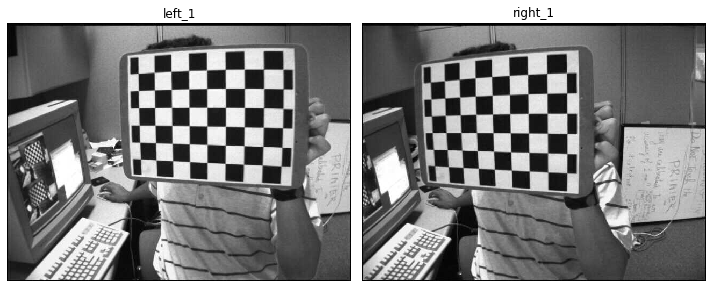

In [3]:
# left_ = [cv2.imread(image) for image in sorted(glob.glob("../../images/task_1/left_*.png"))]
# right_ = [cv2.imread(image) for image in sorted(glob.glob("../../images/task_1/right_*.png"))]

left_ = [cv2.imread(image) for image in sorted(glob.glob("../../images/opencv_sample_calibration_images/left*"))]
right_ = [cv2.imread(image) for image in sorted(glob.glob("../../images/opencv_sample_calibration_images/right*"))]

import matplotlib.pyplot as plt
def plot_figures(figures, nrows=1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10,10))
    if(nrows > 1 or ncols > 1):
        for ind,title in enumerate(figures):
            axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
            axeslist.ravel()[ind].set_title(title)
            axeslist.ravel()[ind].set_axis_off()
        plt.tight_layout() # optional
    else:
        for ind,title in enumerate(figures):
            axeslist.imshow(figures[title], cmap=plt.gray())
            axeslist.set_title(title)
            axeslist.set_axis_off()
            

plot_figures({'left_1': left_[0], 'right_1': right_[0]}, 1, 2)

In [4]:
s = cv2.FileStorage('../task_1/calibrated_camera_parameters.xml', cv2.FileStorage_READ)

mtx_left = s.getNode('mtx_left').mat()
distCoeffs_left = s.getNode('distCoeffs_left').mat()

mtx_right = s.getNode('mtx_right').mat()
distCoeffs_right = s.getNode('distCoeffs_right').mat()

# Step (2): Extract 3D-to-2D point correspondences :

This is the same as task 1 step (2). The only difference is that in this task there are two sets of 2D points for both cameras. The 3D points are the same as those in task 1 step (2).


In [5]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

rows = 6
columns = 9

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(columns,5,0)
objp = np.zeros((columns*rows,3), np.float32)
objp[:,:2] = np.mgrid[0:columns,0:rows].T.reshape(-1,2)
# objp = objp*25.4   # only use when using the images from Duo

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space

In [6]:
imgpoints_left = [] # 2d points in image plane.

for img_og in left_:
    img = img_og.copy()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (columns,rows),None)
    print(ret,end=' ')
    
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)   # this does not do anything
        imgpoints_left.append(corners2)

True True True True True True True True True True True True True 

In [7]:
imgpoints_right = [] # 2d points in image plane.

for img_og in right_:
    img = img_og.copy()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (columns,rows),None)
    print(ret,end=' ')
    
    # If found, add object points, image points (after refining them)
    if ret == True:
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)   # this does not do anything
        imgpoints_right.append(corners2)

True True True True True True True True True True True True True 

# Step (3): Calibrate the stereo camera :
Once the 3D-to-2D point correspondences are obtained, call OpenCV library function "stereoCalibrate()" to calculate the parameters between the two views, including the translation, rotation, the fundamental matrix, and the essential matrix. Note that the "CALIB_FIX_INTRINSIC" flag should be set and the camera intrinsics should be provided when you call the stereo calibration library function.

## calibrateCamera():

C++: double calibrateCamera(InputArrayOfArrays objectPoints, InputArrayOfArrays imagePoints, Size imageSize, InputOutputArray cameraMatrix, InputOutputArray distCoeffs, OutputArrayOfArrays rvecs, OutputArrayOfArrays tvecs, int flags=0, TermCriteria criteria=TermCriteria( TermCriteria::COUNT+TermCriteria::EPS, 30, DBL_EPSILON) )

Python: cv2.calibrateCamera(objectPoints, imagePoints, imageSize[, cameraMatrix[, distCoeffs[, rvecs[, tvecs[, flags[, criteria]]]]]]) → retval, cameraMatrix, distCoeffs, rvecs, tvecs¶

## stereoCalibrate():

C++: double stereoCalibrate(InputArrayOfArrays objectPoints, InputArrayOfArrays imagePoints1, InputArrayOfArrays imagePoints2, InputOutputArray cameraMatrix1, InputOutputArray distCoeffs1, InputOutputArray cameraMatrix2, InputOutputArray distCoeffs2, Size imageSize, OutputArray R, OutputArray T, OutputArray E, OutputArray F, TermCriteria criteria=TermCriteria(TermCriteria::COUNT+TermCriteria::EPS, 30, 1e-6), int flags=CALIB_FIX_INTRINSIC )

Python: cv2.stereoCalibrate(objectPoints, imagePoints1, imagePoints2, imageSize[, cameraMatrix1[, distCoeffs1[, cameraMatrix2[, distCoeffs2[, R[, T[, E[, F[, criteria[, flags]]]]]]]]]]) → retval, cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, R, T, E, F


In [18]:
ret, mtx_left, distCoeffs_left, rvecs_left, tvecs_left = cv2.calibrateCamera(objpoints, imgpoints_left, (640, 480),None,None)

ret, mtx_right, distCoeffs_right, rvecs_right, tvecs_right = cv2.calibrateCamera(objpoints, imgpoints_right, (640, 480),None,None)

In [22]:
distCoeffs_left

array([[-0.26509011, -0.04674355,  0.00183301, -0.00031471,  0.25231509]])

In [9]:
type(tuple(distCoeffs_left[0])[0])

numpy.float64

In [10]:
distCoeffs_left_tuple = []
for x in distCoeffs_left[0]:
    distCoeffs_left_tuple.append(float(x))

In [11]:
type(distCoeffs_left_tuple[0])

float

In [19]:
stereocalib_criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 1e-5)
temp = cv2.stereoCalibrate(objpoints, 
                           imgpoints_left, 
                           imgpoints_right, 
                           (640, 480), 
                           mtx_left,
                           distCoeffs_left,
                           mtx_right,
                           distCoeffs_right,
                           criteria=stereocalib_criteria,
                           flags=cv2.CALIB_FIX_INTRINSIC)

SystemError: new style getargs format but argument is not a tuple

In [13]:
stereocalib_criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 1e-5)
temp = cv2.stereoCalibrate(objpoints, 
                           tuple(imgpoints_left), 
                           tuple(imgpoints_right), 
                           (640, 480), 
                           tuple(mtx_left),
#                            tuple(distCoeffs_left),
                           tuple(distCoeffs_left[0]),
                           tuple(mtx_right),
                           distCoeffs_right[0],
                           criteria=stereocalib_criteria,
                           flags=cv2.CALIB_FIX_INTRINSIC)

TypeError: Expected Ptr<cv::UMat> for argument 'distCoeffs1'

In [26]:
stereocalib_criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 1e-5)
temp = cv2.stereoCalibrate(objpoints, 
                           tuple(imgpoints_left), 
                           tuple(imgpoints_right), 
                           (640, 480), 
                           tuple(mtx_left),
                           id(cv2.UMat(distCoeffs_left)),
                           tuple(mtx_right),
                           distCoeffs_right[0],
                           criteria=stereocalib_criteria,
                           flags=cv2.CALIB_FIX_INTRINSIC)

TypeError: Expected Ptr<cv::UMat> for argument 'distCoeffs1'

In [25]:
id(cv2.UMat(distCoeffs_left[0]))

139618385857648

https://stackoverflow.com/questions/39595291/cv2-stereocalibrate-error-about-cameramatrix-not-being-a-numerical-tuple

In [ ]:
print(R, T, E, F)

# Step (4): Check results by plotting in 3D
https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#triangulatepoints


Python: cv2.triangulatePoints(projMatr1, projMatr2, projPoints1, projPoints2[, points4D]) → points4D

Python: cv2.undistortPoints(src, cameraMatrix, distCoeffs[, dst[, R[, P]]]) → dst


In [ ]:
undistortedPoints_left = []

for imgpoints in imgpoints_left:
    undistortedPoints_left.append(cv2.undistortPoints(imgpoints, cameraMatrix1, distCoeffs1, None, None, None))

# np.array_equal(np.array(dst), np.array(imgpoints_left[0]))

In [ ]:
undistortedPoints_right = []

for imgpoints in imgpoints_right:
    undistortedPoints_right.append(cv2.undistortPoints(imgpoints, cameraMatrix1, distCoeffs1, None, None, None))


In [ ]:
points4D = cv2.triangulatePoints(cameraMatrix1, cameraMatrix2, undistortedPoints_left[0], undistortedPoints_right[0], None)
points4D